In [1]:
import schist as scs
import scanpy as sc
import pandas as pd
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata = sc.datasets.blobs(2)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

In [36]:
adata = scs.io.read("10XV3_075")

In [37]:
import graph_tool.all as gt
g = scs._utils.get_graph_tool_from_adjacency(adata.obsp['connectivities'], directed=False)

In [38]:
n_sweep = 10
beta = np.inf
samples = 100
n_jobs = 4
tolerance = 1e-6
seeds = np.random.choice(range(samples**2), size=samples, replace=False)
def fast_min(state, beta, n_sweep, fast_tol, seed=None):
    if seed:
        gt.seed_rng(seed)
    dS = 1
    while np.abs(dS) > fast_tol:
        dS, _, _ = state.multiflip_mcmc_sweep(beta=beta, niter=n_sweep, c=0.5)
    return state


In [39]:
states = [gt.NestedBlockState(g) for x in range(samples)]

In [40]:
from joblib import Parallel, delayed

In [41]:
states = Parallel(n_jobs=n_jobs)(
    delayed(fast_min)(states[x], beta, n_sweep, tolerance, seeds[x]) for x in range(samples)
)


In [42]:
pmode = gt.PartitionModeState([x.get_bs() for x in states], converge=True, nested=True)
bs = pmode.get_max_nested()

In [86]:
import pickle
pickle.dump(pmode, open('test.pkl', 'wb'), 2)

In [44]:
max_level = max([len(x.get_levels()) for x in states])

In [45]:
g_marginal = np.array([[x.get_levels()[l].get_nonempty_B() for l in range(max_level)] for x in states])

In [49]:
g_marginal

array([[58, 14,  5, ...,  1,  1,  1],
       [56, 13,  4, ...,  1,  1,  1],
       [56, 12,  4, ...,  1,  1,  1],
       ...,
       [54, 11,  4, ...,  1,  1,  1],
       [58, 14,  5, ...,  1,  1,  1],
       [53, 13,  5, ...,  1,  1,  1]])

(array([0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.05, 0.08,
        0.13, 0.29, 0.2 , 0.13, 0.06, 0.03, 0.  , 0.  ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <BarContainer object of 19 artists>)

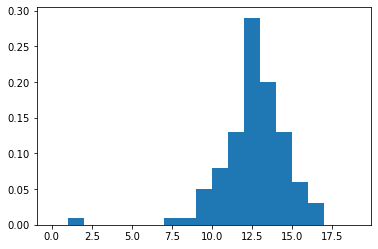

In [68]:
hist(g_marginal[:, 1], bins=np.arange(0, 20), density=True)

In [65]:
import scipy.stats

In [66]:
scipy.stats.mode(g_marginal, axis=0)

ModeResult(mode=array([[55, 12,  4,  2,  1,  1,  1,  1,  1,  1,  1,  1]]), count=array([[ 14,  29,  48,  87,  99, 100, 100, 100, 100, 100, 100, 100]]))

In [55]:
    
# prune redundant levels at the top
bs = [x for x in bs if len(np.unique(x)) > 1]
bs.append(np.array([0], dtype=np.int32)) #in case of type changes, check this
state = gt.NestedBlockState(g, bs)

In [60]:
state.get_levels()[0]

<BlockState object with 61 blocks (55 nonempty), degree-corrected, for graph <Graph object, undirected, with 1523 vertices and 21447 edges, 1 internal edge property, at 0x7f832e23b8e0>, at 0x7f82d3036c40>

In [88]:
pp = pickle.load(open('test.pkl', 'rb'))

In [107]:
nested_P = pp.get_nested_partitions()

In [125]:
import scipy.sparse

In [126]:
scipy.sparse.csr_matrix(g_marginal)

<100x12 sparse matrix of type '<class 'numpy.int64'>'
	with 1200 stored elements in Compressed Sparse Row format>

In [127]:
scipy.sparse.csr_matrix(g_marginal - 1)

<100x12 sparse matrix of type '<class 'numpy.int64'>'
	with 386 stored elements in Compressed Sparse Row format>

In [118]:
g_marginal2 = np.array([[len(np.unique(nested_P[x][l].a[nested_P[x][l].a > -1])) for l in range(max_level)] for x in nested_P])

In [119]:
g_marginal

array([[58, 14,  5, ...,  1,  1,  1],
       [56, 13,  4, ...,  1,  1,  1],
       [56, 12,  4, ...,  1,  1,  1],
       ...,
       [54, 11,  4, ...,  1,  1,  1],
       [58, 14,  5, ...,  1,  1,  1],
       [53, 13,  5, ...,  1,  1,  1]])

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  3.,  3.,  3.,  1.,  3.,  3.,  5.,  5.,  5.,  9.,  8., 14.,
         6.,  6.,  9.]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <BarContainer object of 29 artists>)

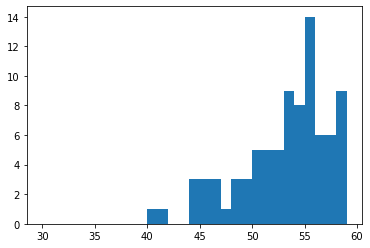

In [121]:
hist(g_marginal[:, 0], bins=np.arange(30, 60))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  3.,  3.,  3.,  1.,  3.,  3.,  5.,  5.,  5.,  9.,  8., 14.,
         6.,  6.,  9.]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <BarContainer object of 29 artists>)

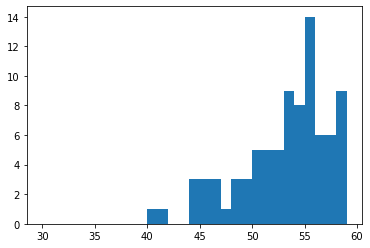

In [122]:
hist(g_marginal2[:, 0], bins=np.arange(30, 60))

In [19]:
bs = pmode.get_max(g)
state = gt.BlockState(g, b=bs)


In [20]:
state

<BlockState object with 25 blocks (23 nonempty), degree-corrected, for graph <Graph object, undirected, with 640 vertices and 5504 edges, 1 internal edge property, at 0x7fcc9b7aee20>, at 0x7fcc9c96f3d0>

In [51]:
adata = schist.io.read('Quartzseq')

In [52]:
schist.inference.nested_model(adata, random_seed=42)

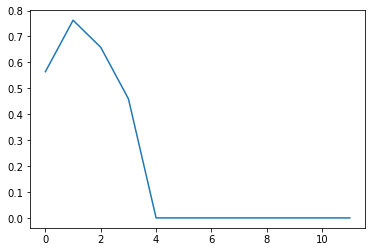

In [53]:
plot(adata.uns['schist']['stats']['modularity'])

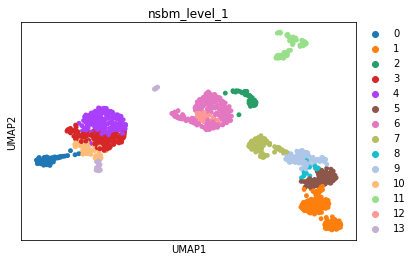

In [54]:
ml = np.argmax(adata.uns['schist']['stats']['modularity'])
sc.pl.umap(adata, color=f'nsbm_level_{ml}')

In [55]:
nested_state = adata.uns['schist']['state'].copy()

In [56]:
schist.inference.planted_model(adata, random_seed=42)

In [57]:
schist.inference.leiden(adata, random_state=42)

In [58]:
pp_state = adata.uns['schist']['state'].copy()

In [59]:
for l in ['ppbm', 'leiden', 'nsbm_level_1', 'nsbm_level_2']:
    adata.obs[f'max_marginal_{l}'] = np.max(adata.obsm[f'CM_{l}'], axis=1)


In [60]:
to_plot = ['ppbm', 'leiden', 'nsbm_level_1', 'nsbm_level_2']
mto_plot = [f'max_marginal_{x}' for x in to_plot ]
p = []
for x in range(len(to_plot)):
    p.append(to_plot[x])
    p.append(mto_plot[x])

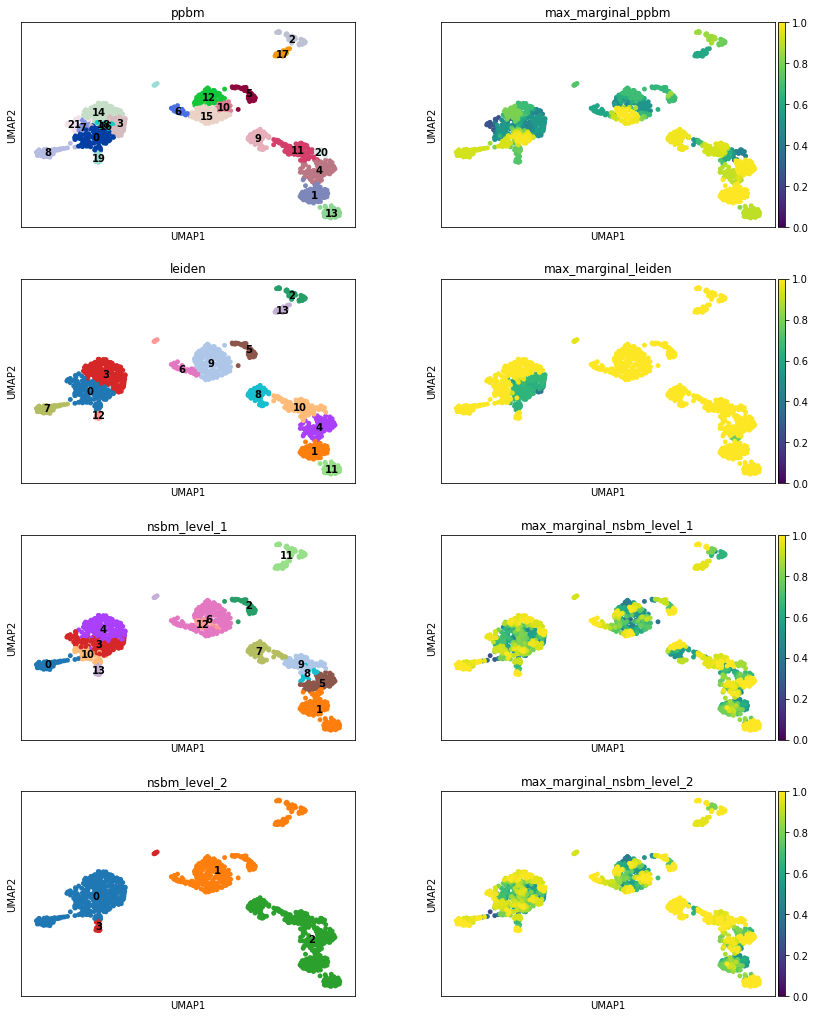

In [61]:
sc.pl.umap(adata, color=p, vmin=0, vmax=1, legend_loc='on data', ncols=2)

In [62]:
adata.obs.filter(like='nsbm_level')

,nsbm_level_0,nsbm_level_1,nsbm_level_2,nsbm_level_3,nsbm_level_4,nsbm_level_5,nsbm_level_6,nsbm_level_7,nsbm_level_8,nsbm_level_9,nsbm_level_10,nsbm_level_11,max_marginal_nsbm_level_1,max_marginal_nsbm_level_2
QUARTZseq_P4S7_AACACCTCGACTCCG,39,10,0,0,0,0,0,0,0,0,0,0,0.80,0.80
QUARTZseq_P4S7_AACCATTAGCAGGAA,1,10,0,0,0,0,0,0,0,0,0,0,0.43,0.58
QUARTZseq_P4S7_AACCGATCAAGTCAA,50,1,2,1,0,0,0,0,0,0,0,0,0.61,0.61
QUARTZseq_P4S7_AACCGCACATAGCGG,2,1,2,1,0,0,0,0,0,0,0,0,0.78,0.78
QUARTZseq_P4S7_AACCGTCGCACCTCT,51,11,1,1,0,0,0,0,0,0,0,0,0.65,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QUARTZseq_P5S8_TTGAACGTTGCTTGG,50,1,2,1,0,0,0,0,0,0,0,0,0.57,0.57
QUARTZseq_P5S8_TTGATACTTCACTCG,2,1,2,1,0,0,0,0,0,0,0,0,0.74,0.74
QUARTZseq_P5S8_TTGCCTCCTTATCGC,21,1,2,1,0,0,0,0,0,0,0,0,1.00,1.00
QUARTZseq_P5S8_TTGGCAACTCTATGA,2,1,2,1,0,0,0,0,0,0,0,0,0.51,0.51
